https://machinelearningmastery.com/imbalanced-classification-of-good-and-bad-credit/

In [14]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

In [15]:
import pandas as pd

pd.set_option( 'display.max_columns' , None ) 

In [16]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv'
    
df = pd.read_csv( url , header = None )

In [17]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


In [18]:
df.shape

(1000, 21)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1000 non-null   object
 1   1       1000 non-null   int64 
 2   2       1000 non-null   object
 3   3       1000 non-null   object
 4   4       1000 non-null   int64 
 5   5       1000 non-null   object
 6   6       1000 non-null   object
 7   7       1000 non-null   int64 
 8   8       1000 non-null   object
 9   9       1000 non-null   object
 10  10      1000 non-null   int64 
 11  11      1000 non-null   object
 12  12      1000 non-null   int64 
 13  13      1000 non-null   object
 14  14      1000 non-null   object
 15  15      1000 non-null   int64 
 16  16      1000 non-null   object
 17  17      1000 non-null   int64 
 18  18      1000 non-null   object
 19  19      1000 non-null   object
 20  20      1000 non-null   int64 
dtypes: int64(8), object(13)
memory usage: 164.2+ KB


In [20]:
from collections import Counter

In [21]:
target = df.values[ : , -1 ]

counter = Counter( target )

print( counter )

Counter({1: 700, 2: 300})


In [22]:
for k , v in counter.items():

    p = v / len( target ) * 100

    print( f'class : {k} | count : {v} | % : {p:.2f} ' )

class : 1 | count : 700 | % : 70.00 
class : 2 | count : 300 | % : 30.00 


In [31]:
last_ix = len( df.columns ) - 1

X = df.drop( last_ix , axis = 1 )

y = df[ last_ix ]


cat_ix = X.select_dtypes( include = [ 'object' , 'bool' ] ).columns

num_ix = X.select_dtypes( include = [ 'int64' , 'float64' ] ).columns

print( cat_ix )

print( num_ix )

Int64Index([0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19], dtype='int64')
Int64Index([1, 4, 7, 10, 12, 15, 17], dtype='int64')


In [32]:
from sklearn.preprocessing import LabelEncoder

In [33]:
y = LabelEncoder().fit_transform( y )

# Baseline Result

In [34]:
from sklearn.metrics import fbeta_score

In [35]:
def f2( y , yhat ) :

    return fbeta_score( y , yhat , beta = 2 )

In [36]:
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score

In [37]:
def evaluate_model( X , y , model ):

    cv = RepeatedStratifiedKFold( n_splits = 10 , n_repeats = 3 , random_state = 999 )

    metric = make_scorer( f2 )

    scores = cross_val_score( model , X , y , scoring = metric , cv = cv , n_jobs = -1 )

    return scores

In [38]:
from sklearn.dummy import DummyClassifier

In [39]:
model = DummyClassifier( strategy = 'constant' , constant = 1 )

In [40]:
from numpy import mean

from numpy import std

In [41]:
scores = evaluate_model( X , y , model )

print( f'dummy model | f2-measure : {mean(scores):.3f} ( {std(scores):.3f} )' )

dummy model | f2-measure : 0.682 ( 0.000 )


# <div class="alert alert-block alert-success">Evaluate Data Undersampling Algorithms</div>

In [50]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler


from imblearn.pipeline import Pipeline


from imblearn.under_sampling import TomekLinks

from imblearn.under_sampling import EditedNearestNeighbours

from imblearn.under_sampling import RepeatedEditedNearestNeighbours

from imblearn.under_sampling import NeighbourhoodCleaningRule

from imblearn.under_sampling import OneSidedSelection

from imblearn.under_sampling import InstanceHardnessThreshold

from imblearn.combine import SMOTEENN


from sklearn.linear_model import LogisticRegression

In [51]:
def get_models():
    
    models = dict()
    
    
    transformer = ColumnTransformer( [ ( 'one_hot_encoding', OneHotEncoder() , cat_ix ) ,
                                       ( 'min_max_scaling' , MinMaxScaler() , num_ix ) ] )
    
    
    steps = [ ( 'step_transforming' , transformer ) ,
              ( 'step_sampling' , TomekLinks() ) ,
              ( 'step_modeling' , LogisticRegression( solver = 'liblinear' , class_weight = 'balanced' ) ) ]

    model = Pipeline( steps = steps )
    
    models[ 'TL' ] = model
    

    
    steps = [ ( 'step_transforming' , transformer ) ,
              ( 'step_sampling' , EditedNearestNeighbours() ) ,
              ( 'step_modeling' , LogisticRegression( solver = 'liblinear' , class_weight = 'balanced' ) ) ]

    model = Pipeline( steps = steps )
    
    models[ 'ENN' ] = model
    
    
    
    steps = [ ( 'step_transforming' , transformer ) ,
              ( 'step_sampling' , RepeatedEditedNearestNeighbours() ) ,
              ( 'step_modeling' , LogisticRegression( solver = 'liblinear' , class_weight = 'balanced' ) ) ]

    model = Pipeline( steps = steps )
    
    models[ 'RENN' ] = model

    
    
    steps = [ ( 'step_transforming' , transformer ) ,
              ( 'step_sampling' , OneSidedSelection() ) ,
              ( 'step_modeling' , LogisticRegression( solver = 'liblinear' , class_weight = 'balanced' ) ) ]

    model = Pipeline( steps = steps )
    
    models[ 'OSS' ] = model
   


    steps = [ ( 'step_transforming' , transformer ) ,
              ( 'step_sampling' , NeighbourhoodCleaningRule() ) ,
              ( 'step_modeling' , LogisticRegression( solver = 'liblinear' , class_weight = 'balanced' ) ) ]

    model = Pipeline( steps = steps )
    
    models[ 'NCR' ] = model

    
    steps = [ ( 'step_transforming' , transformer ) ,
              ( 'step_sampling' , InstanceHardnessThreshold() ) ,
              ( 'step_modeling' , LogisticRegression( solver = 'liblinear' , class_weight = 'balanced' ) ) ]

    model = Pipeline( steps = steps )
    
    models[ 'IHT' ] = model
    
    
    
    steps = [ ( 'step_transforming' , transformer ) ,
              ( 'step_sampling' , SMOTEENN( enn = EditedNearestNeighbours( sampling_strategy = 'majority' ) ) ) ,
              ( 'step_modeling' , LogisticRegression( solver = 'liblinear' , class_weight = 'balanced' ) ) ]

    model = Pipeline( steps = steps )
    
    models[ 'SMOTEENN' ] = model
    
    
    return models

In [52]:
models = get_models()

print( models )

{'TL': Pipeline(steps=[('step_transforming',
                 ColumnTransformer(transformers=[('one_hot_encoding',
                                                  OneHotEncoder(),
                                                  Int64Index([0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19], dtype='int64')),
                                                 ('min_max_scaling',
                                                  MinMaxScaler(),
                                                  Int64Index([1, 4, 7, 10, 12, 15, 17], dtype='int64'))])),
                ('step_sampling', TomekLinks()),
                ('step_modeling',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))]), 'ENN': Pipeline(steps=[('step_transforming',
                 ColumnTransformer(transformers=[('one_hot_encoding',
                                                  OneHotEncoder(),
                                                  Int64Index([0,

In [53]:
models = get_models()

results = list()

names = list()


for name , model in models.items() :
    
    names.append( name )
    
    scores = evaluate_model( X , y , model ) 
    
    results.append( scores )
    
    print( f' model : {name} : {mean(scores):.3f} ( {std(scores):.3f} )' )

 model : TL : 0.666 ( 0.067 )
 model : ENN : 0.702 ( 0.062 )
 model : RENN : 0.707 ( 0.070 )
 model : OSS : 0.664 ( 0.068 )
 model : NCR : 0.690 ( 0.061 )
 model : IHT : 0.727 ( 0.052 )
 model : SMOTEENN : 0.697 ( 0.060 )


In [54]:
from matplotlib import pyplot

{'whiskers': [<matplotlib.lines.Line2D at 0x20454630>,
 'caps': [<matplotlib.lines.Line2D at 0x20454cc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20454240>,
 'medians': [<matplotlib.lines.Line2D at 0x2045d390>,
 'fliers': [<matplotlib.lines.Line2D at 0x20435e48>,
 'means': [<matplotlib.lines.Line2D at 0x2045d6d8>,
  <matplotlib.lines.Line2D at 0x200847f0>]}

(array([1, 2, 3, 4, 5, 6, 7]), <a list of 7 Text xticklabel objects>)

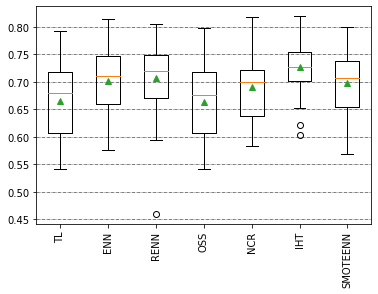

In [55]:
pyplot.boxplot( results , labels = names , showmeans = True )

pyplot.grid( axis = 'y' , color = 'black' , linestyle = '-.' , linewidth = 0.5 )

pyplot.xticks( rotation = 90 )

pyplot.show()